In [47]:
import numpy as np
import nysg_tools as ny 
import pandas as pd
from math import log10
import pyvisa as visa
import matplotlib.pyplot as plt

In [48]:
rm = visa.ResourceManager()

In [49]:
rm.list_resources()

('ASRL1::INSTR', 'ASRL10::INSTR')

In [50]:
osci_name = "USB0::0x0699::0x0368::C017041::INSTR"
fungen_name = "USB0::0x0699::0x0353::2139465::INSTR"

In [51]:
osci = rm.open_resource(osci_name)
fungen = rm.open_resource(fungen_name)

In [52]:
fungen.write("SOURCE1:FREQ 5")

VisaIOError: VI_ERROR_SYSTEM_ERROR (-1073807360): Unknown system error (miscellaneous error).

In [8]:
fungen.write("SOURCE1:FUNC SQUARE")

21

In [9]:
def get_osci(additional_info = False, plot=False):
    osci.write("DAT:SOU CH1")
    xze, xin = osci.query_ascii_values('WFMPRE:XZE?;XIN?', separator=';')
    yze1, ymu1, yoff1 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')
    osci.write("DAT:SOU CH2")

    yze2, ymu2, yoff2 = osci.query_ascii_values('WFMPRE:YZE?;YMU?;YOFF?;', separator=';')

    osci.write('DAT:ENC RPB')
    osci.write('DAT:WID 1')

    osci.write("DAT:SOU CH1")
    data1 = osci.query_binary_values('CURV?', datatype='B', container=np.array)

    osci.write("DAT:SOU CH2")
    data2 = osci.query_binary_values('CURV?', datatype='B', container=np.array)

    tiempo = xze + np.arange(len(data1)) * xin

    data1v = (data1 - yoff1) * ymu1 + yze1
    data2v = (data2 - yoff2) * ymu2 + yze2
    
    if plot:
        plt.plot(tiempo,data1v)
        plt.plot(tiempo,data2v)

    if additional_info:
        extra = {"yze1":yze1,"ymu1":ymu1,"yoff1":yoff1,"yze2":yze2,"ymu2":ymu2,"yoff2":yoff2,"datach1raw":data1,"datach2raw":data2}
        return tiempo,data1v,data2v, extra

    return tiempo,data1v,data2v

def osci_autosave(filename,attrs,plot_saved=False):
    t,v1,v2 = get_osci()
    buffer =  pd.DataFrame({"time":t,"VCH1":v1,"VCH2":v2})

    buffer.attrs = attrs
    
    buffer.to_csv(f'{filename}{".csv"}')
    buffer.to_pickle(f'{filename}')

    if plot_saved:
        plt.plot(t,v1)
        plt.plot(t,v2)


def osci_autosave_simple(filename):
    t,v1,v2 = get_osci()
    buffer =  pd.DataFrame({"time":t,"VCH1":v1,"VCH2":v2})

    buffer.to_pickle(f'{filename}')

In [46]:
t, v1, v2 = get_osci()

plt.plot(t, v1)
plt.legend("Vin")
plt.plot(t, v2)
plt.xlabel('Tiempo [s]')
plt.ylabel('Voltaje [V]')


VisaIOError: VI_ERROR_SYSTEM_ERROR (-1073807360): Unknown system error (miscellaneous error).

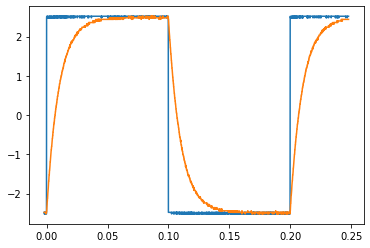

In [15]:
## Primera data

attrs = {"Freq":5, "Res":10000,"cap":1*10**(-6),"amplt":5,"onda_entrada":"cuadrada","Tipo_de_circuito":"Integrador"}

osci_autosave("dataAri/data1",attrs=attrs,plot_saved=True)

## Ajuste primera data

In [17]:
data = pd.read_pickle("dataAri/data1")
t = data['time'].to_numpy()
vin = data['VCH1'].to_numpy()
vout = data['VCH2'].to_numpy()
print(data.attrs)

{'Freq': 5, 'Res': 10000, 'cap': 1e-06, 'amplt': 5, 'onda_entrada': 'cuadrada', 'Tipo_de_circuito': 'Integrador'}


In [44]:
x1 = t[0:998]
y1 = vout[0:998]
yerr1 = 0.04
xerr1 = np.full_like(x1,1/2500)
def discharge(par, x):
    return par[0] * np.exp(x/(par[1])) + par[2]

def discharge_2(x,x0,a,b, c):
    return a * np.exp(-(x-x0)/b) + c

p1 = ny.fit_lsq(x1,y1,discharge_2,p0=[0,0.01, 1, 0],yerr=np.full_like(y1,yerr1),maxfev=1000000000)

La función es:
None
Resultados del ajuste:
Parámetro x0: 1.069 ± nan
Parámetro a: -0.0 ± nan
Parámetro b: 0.011 ± 0.0
Parámetro c: 2.498 ± 0.003
Parametros de bondad:
ν: 993
χ²: 2871.679
χ²/ν:2.892
Criterio 5%: (919.468, 1066.532)


c:\Users\publico.LABORATORIOS\Anaconda3\lib\site-packages\nysg_tools\main.py:128: RuntimeWarning: invalid value encountered in sqrt
  perr = np.sqrt(np.diag(pcov))


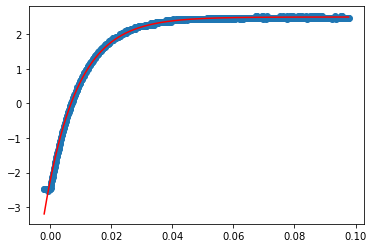

In [45]:
plt.scatter(x1,y1)
plt.plot(x1,discharge_2(x1,*p1['params']),c='r')